In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pandas import Series, DataFrame
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_context('notebook')

In [2]:
import ipywidgets as wgts
from ipywidgets import interactive, IntSlider, ToggleButtons, FloatSlider

from sklearn.metrics import mean_squared_error

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_forecasts(y_train, y_test, y_pred, m):
    """
    """
    fig, ax = plt.subplots(figsize=(15, 5)) 
    y_train.plot(ax=ax, label='train')
    y_test.plot(ax=ax, label='actual')
    y_pred.plot(ax=ax, label='predicted')
    m.fittedvalues.plot(ax=ax, alpha=0.5, label='fitted', style='--')
    plt.legend(loc='best')
    
    print(f"""\n\nMetrics -> 
    BIC = {m.bic}, 
    AIC = {m.aic}, 
    RMSE = {np.sqrt(mean_squared_error(y_test, y_pred)).round(2)},
    MAPE = {mean_absolute_percentage_error(y_test, y_pred).round(2)}
    \n""")

    ;

def plot_residuals(y_test, y_pred):
    """
    """
    delta = y_test - y_pred
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 4)) 
    delta.plot(ax=axs[0], title='Residuals', style='k--', alpha=0.6)
    delta.plot.hist(ax=axs[1], bins=20, title='Distribution', color='k', alpha=0.5);

---
# `Get Data`

In [4]:
# !pip install yfinance
import yfinance as yf

ticker = 'MSFT'

y = \
(yf.download(ticker,'2018-01-01','2020-01-01')
 .loc[:, 'Close']
 .loc[:, ticker]
 .astype(float)
 .resample('D')
 .mean()
 .interpolate('time')
 .pipe(pd.Series, name='y')
)

y.index.name = 'Time'

[*********************100%***********************]  1 of 1 completed


# Time Series EDA

- (i) First determine whether a nonlinear transformation such as logging is necessary to
straighten out exponential growth curves and/or stabilize the variance (i.e., to make the local
random variations in the series roughly the same in magnitude from beginning to end). If so, then
apply the transformation. 

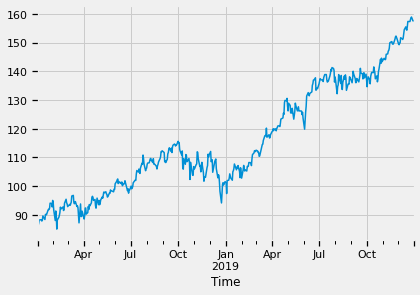

In [5]:
y.plot();

- (ii) If the series looks nonstationary at this point—i.e., if it displays a trend or random-walk
behavior—set the order of nonseasonal differencing to 1.

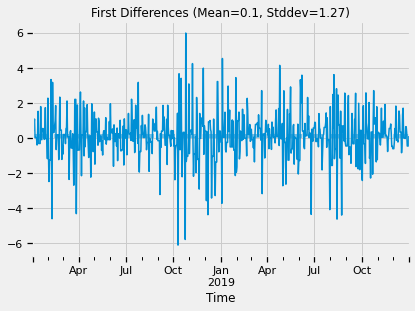

In [6]:
ax = y.diff(1).plot(title=f'First Differences (Mean={y.diff(1).mean().round(2)}, Stddev={y.diff(1).std().round(2)})')
ax.hlines(y=y.diff(1).mean(), xmin=y.index[0], xmax=y.index[-1], linestyles='--', alpha=0.5, linewidth=4);

- (iii) Look at the ACF and PACF plots of the series you have at this point. 
    - If you don’t see any significant autocorrelations, then stop — you’re done! 
    - You’ve identified either a mean model or a random walk model, depending on whether you used 0 or 1 order of differencing

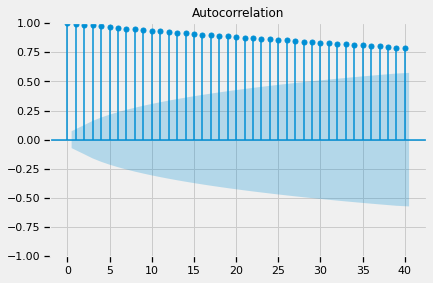

In [7]:
plot_acf(y, lags=40);

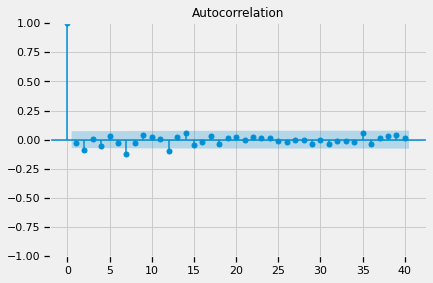

In [8]:
plot_acf(y.diff(1).dropna(), lags=40);

- (iv) If you do see some significant autocorrelations,  
    - if the first one or two bars on the ACF plot are significant and negative, followed by a fairly sharp cutoff, while the PACF plot shows a
     more gradual decay pattern from below, that is a clear sign that you need at least one MA term (i.e., q=1 or q=2). 
    - On the other hand, if the first one or two bars on the PACF plot are significant and positive, followed by a fairly sharp cutoff, while the ACF plot shows a more gradual decay pattern from above, that is a clear sign that you need at least one AR term (i.e., p=1 or p=2).
    
---

- Fit the model and look at the ACF and PACF and time series plot of the residuals. 
    - If any of the first one or two bars are significant in the ACF or PACF plot, apply the same reasoning as above to determine whether to increase the MA order
or AR order by one more. 
    - You should not go above 2 except in very rare circumstances. 
    - Also, you should use only AR coefficients or only MA coefficients except in very rare circumstances
    
---

- (v) Do not pay any attention to isolated spikes in the ACF or PACF plot beyond lag 3 if you are
working with nonseasonal data. 

--- 

- (vi) If the residuals of the model you converged on in step (iv) do not look quite stationary—e.g.,
if there is a sort of “wave” pattern or other nonrandom pattern in the residuals, then you may want
to increase the order of differencing.

---
# Train-Test Split

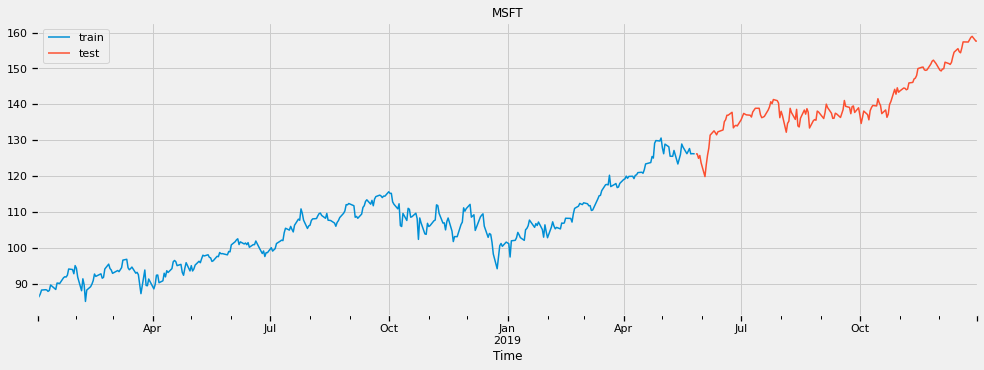

In [10]:
train_size = int(len(y) * 0.70)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

y_train.plot(figsize=(15, 5), title=ticker, label='train')
y_test.plot(label='test')
plt.legend();

---
# Exponential Smoothing Models

## `SimpleExpSmoothing`

In [11]:
def f(smoothing_level, optimized):
    """
    """
    m = SimpleExpSmoothing(endog=y_train).fit(smoothing_level=smoothing_level, optimized=optimized)
    y_pred = m.forecast(steps=len(y_test))
    plot_forecasts(y_train, y_test, y_pred, m)
    plot_residuals(y_test, y_pred)
    return None

interactive(f,
            smoothing_level=wgts.FloatSlider(value=0.5, min=0, max=2, step=0.1),
            optimized=ToggleButtons(options=[True, False])
           )

interactive(children=(FloatSlider(value=0.5, description='smoothing_level', max=2.0), ToggleButtons(descriptio…

## `ExponentialSmoothing`

In [12]:
def f(trend, damped, smoothing_level):
    """
    """
    m = ExponentialSmoothing(endog=y_train, trend=trend, damped=damped).fit(smoothing_level=smoothing_level, optimized=True)
    y_pred = m.forecast(steps=len(y_test))
    plot_forecasts(y_train, y_test, y_pred, m)
    plot_residuals(y_test, y_pred)    
    return None

interactive(f,
            trend = ToggleButtons(description='Trend = ', options=["add", "mul"], value='add'),
            damped = ToggleButtons(description='Damped = ', options=[True, False], value=False),
            smoothing_level=wgts.FloatSlider(description='Smoothing = ', value=0.5, min=0, max=2, step=0.2)
           )

interactive(children=(ToggleButtons(description='Trend = ', options=('add', 'mul'), value='add'), ToggleButton…

## `Holt`

In [17]:
def f(exponential_, smoothing_level_, smoothing_slope_):
    """
    """
    m = (Holt(endog=y_train, 
              exponential=exponential_)
         .fit(smoothing_level=smoothing_level_, 
              smoothing_slope=smoothing_slope_)
        )
    y_pred = m.forecast(steps=len(y_test))
    # print(y_pred.head())
    # print(y_train.tail())
    # print(y_test.head())
    plot_forecasts(y_train, y_test, y_pred, m)
    plot_residuals(y_test, y_pred)    
    
interactive(f,
            exponential_ = ToggleButtons(value=False, options=[True, False], description='Exponential? '),
            smoothing_level_ = wgts.FloatSlider(value=0.2, min=0., max=1.5, step=0.1, description='Smoothing Level'),
            smoothing_slope_ = wgts.FloatSlider(value=0.02, min=0., max=0.5, step=0.02, description='Smoothing Slope'),
           )    

interactive(children=(ToggleButtons(description='Exponential? ', index=1, options=(True, False), value=False),…

---
# Non Seasonal `ARIMA`

## EDA

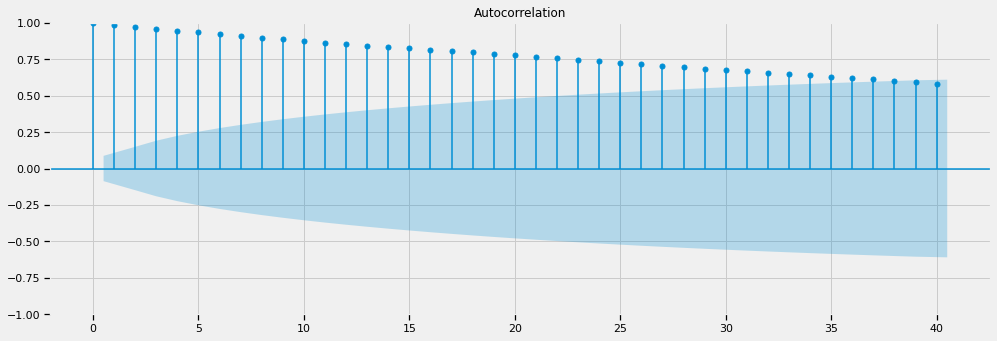

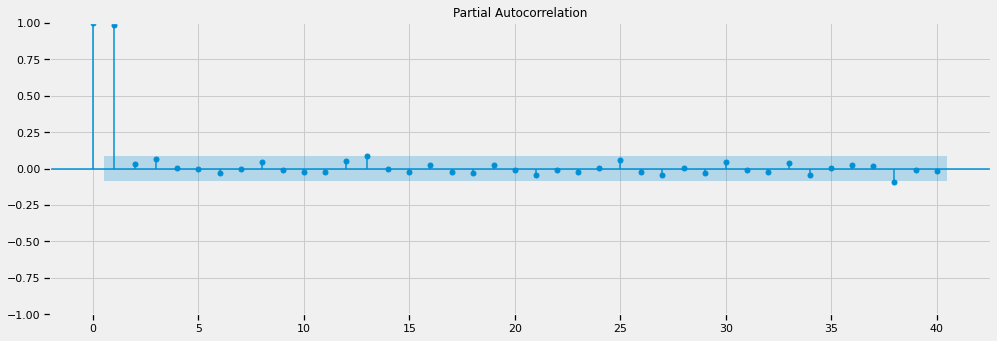

In [18]:
plt.rcParams['figure.figsize'] = (15, 5)
plot_acf(y_train, lags=40);
plot_pacf(y_train, lags=40);

- PACF cuts-off after Lag=1, and ACF decays slowly
    - This is the AR(1) signature

In [20]:
from statsmodels.tsa.arima.model import ARIMA

In [23]:
m = ARIMA(endog=y_train, order=(1, 0, 1))

In [ ]:
m.fit()

In [22]:
def f(p, d, q, constant):
    """
    Interactive widget to fit ARIMA Model
    """
    m = ARIMA(endog=y_train, order=(p, d, q)).fit()
    y_pred = m.predict(start=y_test.index.min(), end=y_test.index.max(), typ='levels')
    plot_forecasts(y_train, y_test, y_pred, m)
    plot_residuals(y_test, y_pred)
    print(f"ARIMA {p, d, q}")
    ;

interactive(f, 
            p = IntSlider(value=1, min=0, max=3, step=1),
            d = IntSlider(value=1, min=0, max=2, step=1),
            q = IntSlider(value=0, min=0, max=3, step=1),
            constant = ToggleButtons(options=['c', 'nc'], description='Constant: '))

interactive(children=(IntSlider(value=1, description='p', max=3), IntSlider(value=1, description='d', max=2), …